# Diseño de Experimentos

### Lectura de Datos

In [1]:
#Importaciones
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
#Lectura de datos
datosGeneracion = pd.read_excel("../Datasets/Información Planta Solar Estacionaria.xlsx")
datosGeneracion_sel = datosGeneracion.copy()
datosGeneracion_sel = datosGeneracion_sel.drop(columns = ['Fecha', 'DesCondCielo', 'DesDirViento'])

In [3]:
#Normalizamos la información
scaler = MinMaxScaler()
scaled = scaler.fit_transform(datosGeneracion_sel)
datosGeneracion_scaled = pd.DataFrame(scaled, columns = datosGeneracion_sel.columns, index=datosGeneracion_sel.index)

In [4]:
#Eliminamos los vacíos
datosGeneracion_dropna = datosGeneracion_scaled.dropna()
datosGeneracion_dropna.head(4)

,Anio,Mes,NumMes,NumSemana,NumDiaAnio,Dia,NumDia,Hora,NumHora,Generacion,...,Generacion_diff,Temperatura_diff,ProbabilidadLluvia_diff,HumedadRelativa_diff,VelocidadViento_diff,DireccionViento_diff,IndiceUV_diff,VelocidadRafaga_diff,Precipitacion_diff,DPT_diff
24,0.0,0.0,0.545455,0.5,0.502778,0.001264,0.033333,0.001263,0.000000,0.0,...,0.500199,0.447368,0.527950,0.500000,0.559045,0.494949,0.444444,0.494208,0.563265,0.507246
25,0.0,0.0,0.545455,0.5,0.502778,0.001264,0.033333,0.001315,0.043478,0.0,...,0.500199,0.473684,0.552795,0.494048,0.584171,0.494949,0.444444,0.494208,0.563265,0.507246
26,0.0,0.0,0.545455,0.5,0.502778,0.001264,0.033333,0.001368,0.086957,0.0,...,0.500199,0.473684,0.534161,0.505952,0.559045,0.494949,0.444444,0.494208,0.563265,0.507246
27,0.0,0.0,0.545455,0.5,0.502778,0.001264,0.033333,0.001420,0.130435,0.0,...,0.500199,0.447368,0.503106,0.500000,0.584171,0.494949,0.444444,0.494208,0.563265,0.492754


In [11]:
#Selección de información
y = datosGeneracion_dropna[['Generacion_diff']]
x = datosGeneracion_dropna[['NumSemana', 'NumDiaAnio', 'Hora','Temperatura_diff', 'ProbabilidadLluvia_diff',
                                 'HumedadRelativa_diff', 'VelocidadViento_diff', 'DireccionViento_diff', 'CoberturaNubes',
                                 'IndiceUV_diff', 'CodCondCielo', 'CodDirViento', 'VelocidadRafaga_diff', 'Precipitacion_diff',
                                 'DPT_diff']]

In [34]:
from tqdm import tqdm
import multiprocessing
from timeit import default_timer as timer
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split

In [36]:
base = 7200
periodo = 2400
n_jobs = multiprocessing.cpu_count()
n_estimadores = range(8)
try:
    results = pd.read_csv('./Resultados_scoring.csv', index_col = 0)
except:
    results = {
        'ts' : [],
        'ne' : [],
        'mf' : [],
        'score' : [],
        'mae' : [],
        'time' : []
    }

    #for r in range(30):
    for ts in [.1, .2, .3, .4]:
        datosGeneracion_train = datosGeneracion_dropna.sample(frac = 1-ts)
        y_train = datosGeneracion_train[['Generacion_diff']]
        x_train = datosGeneracion_train[['NumSemana', 'NumDiaAnio', 'Hora', 'ProbabilidadLluvia_diff',
                                            'CoberturaNubes', 'CodDirViento', 'DPT_diff', 'VelocidadViento_diff',
                                            'Temperatura_diff', 'IndiceUV_diff', 'CodCondCielo']]
        datosGeneracion_test = datosGeneracion_dropna.drop(datosGeneracion_train.index)
        y_test = datosGeneracion_test[['Generacion_diff']]
        x_test = datosGeneracion_test[['NumSemana', 'NumDiaAnio', 'Hora', 'ProbabilidadLluvia_diff',
                                        'CoberturaNubes', 'CodDirViento', 'DPT_diff', 'VelocidadViento_diff',
                                        'Temperatura_diff', 'IndiceUV_diff', 'CodCondCielo']]
        for ne in n_estimadores:
            for mf in ['sqrt', 'log2', None]:
                start = timer()
                model = RandomForestRegressor(n_estimators= 2 ** ne, max_features=mf, n_jobs=n_jobs)
                model.fit(x_train, y_train)
                pred = model.predict(x_test)
                end = timer()
                results['ts'].append(ts)
                results['ne'].append(ne)
                results['mf'].append(mf)
                results['score'].append(model.score(x_test, y_test))
                results['mae'].append(mae(y_test, pred))
                results['time'].append(end - start)
    df_results = pd.DataFrame(results)
    df_results.to_csv('./Resultados_scoring.csv')

In [37]:
df_results.sort_values('mae', ascending=True)

,ts,ne,mf,score,mae,time
21,0.1,7,sqrt,0.341195,0.036189,6.353034
45,0.2,7,sqrt,0.348362,0.036440,5.202468
46,0.2,7,log2,0.352059,0.036608,5.246666
19,0.1,6,log2,0.341489,0.036645,3.552389
22,0.1,7,log2,0.329425,0.036693,5.971120
...,...,...,...,...,...,...
73,0.4,0,log2,-0.491087,0.056172,0.119976
50,0.3,0,NaN,-0.505327,0.056332,0.413478
74,0.4,0,NaN,-0.462299,0.056682,0.418151
72,0.4,0,sqrt,-0.480350,0.057422,0.145775


## Método Random Forest

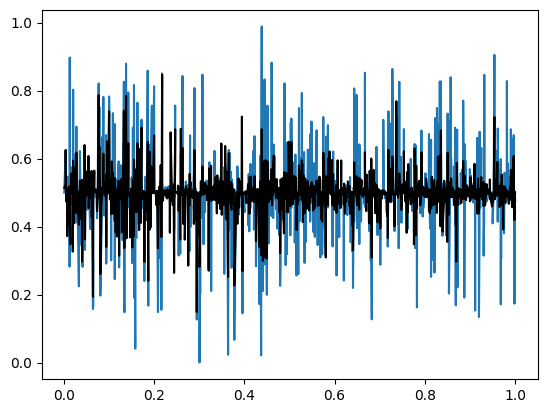

In [40]:
import matplotlib.pyplot as plt
datosGeneracion_train = datosGeneracion_dropna.sample(frac = 0.9)
y_train = datosGeneracion_train[['Generacion_diff']]
x_train = datosGeneracion_train[['NumSemana', 'NumDiaAnio', 'Hora', 'ProbabilidadLluvia_diff',
                                    'CoberturaNubes', 'CodDirViento', 'DPT_diff', 'VelocidadViento_diff',
                                    'Temperatura_diff', 'IndiceUV_diff', 'CodCondCielo']]
datosGeneracion_test = datosGeneracion_dropna.drop(datosGeneracion_train.index)
y_test = datosGeneracion_test[['Generacion_diff']]
x_test = datosGeneracion_test[['NumSemana', 'NumDiaAnio', 'Hora', 'ProbabilidadLluvia_diff',
                                'CoberturaNubes', 'CodDirViento', 'DPT_diff', 'VelocidadViento_diff',
                                'Temperatura_diff', 'IndiceUV_diff', 'CodCondCielo']]
modelRF = RandomForestRegressor(n_jobs=n_jobs, n_estimators=2**7, max_features='sqrt')
modelRF.fit(x_train, y_train)
y_pred_RF = modelRF.predict(x_test)
plt.plot(x_test["Hora"], y_test)
plt.plot(x_test["Hora"], y_pred_RF, c = 'black')